# Dependency

In [1]:
### Preparation

# Data processing
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
import missingno as miss
from pandas.api.types import CategoricalDtype # Ordering categories
import re
# Connection to sql
import sqlite3

# Data Viz Libraries
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import wordcloud # Wordcloud
from PIL import Image # For mask

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Web-scraping libraries
import requests # For downloading the website
from bs4 import BeautifulSoup # For parsing the website
import time # To put the system to sleep
import random # for random numbers

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import LinearSVC as SVC
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

# Part 1 Top 50 Cities with Accumulated Most H1B Filings (YR 2019 Data)

## Data Collection

In [2]:
### Create a list of urls to scrape

# Parse the main page
url_main = 'https://h1bdata.info/topcities.php'
soup_1 = BeautifulSoup(requests.get(url_main).content, 'html.parser')
    
# Extract relevant links
links = []
for tag in soup_1.find_all("a"):
    href = tag.attrs.get("href")
    if "city=" in href and "https:" not in href:
        links.append("https://h1bdata.info/" + href.replace("2020","2018"))
        
target = links[0:50]

In [3]:
### Building a scraper for a single page

def h1b_scraper(url=None):
    """Scrape a single BIT URL (link when clicking a country).

    Args:
        url: A h1b url to scrape.

    Returns:
        DataFrame: frame containing the first table following a given BIT url
    """

    # Download the webpage
    page = requests.get(url)

    # If a connection was reached
    if page.status_code == 200:

        # Parse
        soup = BeautifulSoup(page.content, 'html.parser')
        
        #Read table
        dat = pd.read_html(page.text)[0]
        
        #grab the city
        city = url.split("=")[-1].replace("+"," ")
        dat["city"] = city

    #Return the data frame
    return dat

In [4]:
### Using the scraper build above to scrape relevant links, and a concat the data to a large data frame

def link_scrape(urls=None,sleep=2):
    """Scrape multiple BIT URLS.

    Args:
        urls (list): list of valid BIT urls.
        sleep (int): Integer value specifying how long the machine should be
                    put to sleep (random uniform). Defaults to 2.

    Returns:
        DataFrame: frame containing tables following each BIT url
    """
    scraped_data = []
    for url in urls:
        
        # Keep track of where we are at
        print(url)

        # Scrape the content, append the data frame to the empty list
        scraped_data.append(h1b_scraper(url))

        # Put the system to sleep for a random draw of time (be kind)
        time.sleep(random.uniform(0,sleep))
        
        # Create a large data frame
        dat = pd.concat(scraped_data)
        
    return dat

In [5]:
target2 = target.copy()

In [6]:
raw = link_scrape(urls=target2)

https://h1bdata.info/index.php?year=2018&city=NEW+YORK
https://h1bdata.info/index.php?year=2018&city=SAN+FRANCISCO
https://h1bdata.info/index.php?year=2018&city=HOUSTON
https://h1bdata.info/index.php?year=2018&city=CHICAGO
https://h1bdata.info/index.php?year=2018&city=ATLANTA
https://h1bdata.info/index.php?year=2018&city=SAN+JOSE
https://h1bdata.info/index.php?year=2018&city=SUNNYVALE
https://h1bdata.info/index.php?year=2018&city=SEATTLE
https://h1bdata.info/index.php?year=2018&city=MOUNTAIN+VIEW
https://h1bdata.info/index.php?year=2018&city=AUSTIN
https://h1bdata.info/index.php?year=2018&city=IRVING
https://h1bdata.info/index.php?year=2018&city=DALLAS
https://h1bdata.info/index.php?year=2018&city=CHARLOTTE
https://h1bdata.info/index.php?year=2018&city=REDMOND
https://h1bdata.info/index.php?year=2018&city=BOSTON
https://h1bdata.info/index.php?year=2018&city=SANTA+CLARA
https://h1bdata.info/index.php?year=2018&city=PLANO
https://h1bdata.info/index.php?year=2018&city=PHILADELPHIA
https:/

In [7]:
raw

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS,city
0,BARCLAYS SERVICES CORP,.NET QLIK DEVELOPER SYSTEMS ENGINEER,125000,"NEW YORK, NY",06/13/2018,07/02/2018,CERTIFIED,NEW YORK
1,VLINKINC,.NET ARCHITECT,85000,"NEW YORK, NY",12/13/2018,12/26/2018,WITHDRAWN,NEW YORK
2,VLINKINC,.NET ARCHITECT,85000,"NEW YORK, NY",12/20/2018,01/03/2019,CERTIFIED,NEW YORK
3,DIGITAL SCRIPTS INC,.NET DEVELOPER,92700,"NEW YORK, NY",11/12/2018,12/28/2018,CERTIFIED,NEW YORK
4,DIGITAL SCRIPTS INC,.NET DEVELOPER,92800,"NEW YORK, NY",08/30/2018,12/28/2018,CERTIFIED,NEW YORK
...,...,...,...,...,...,...,...,...
1693,ENTREGA SYSTEMS GROUP INC,WEB APPLICATION DEVELOPER,62000,"TROY, MI",03/30/2018,09/08/2018,CERTIFIED,TROY
1694,BROADGATE INC,WEB DEVELOPER,60000,"TROY, MI",02/20/2018,03/01/2018,CERTIFIED,TROY
1695,ELIX INC,WEB DEVELOPER,71635,"TROY, MI",03/30/2018,09/28/2018,CERTIFIED,TROY
1696,PRECISION TECHNOLOGIES CORP,WINDOWS ADMINISTRATOR,61420,"TROY, NY",04/17/2018,04/17/2018,CERTIFIED,TROY


In [8]:
# Make a copy of raw to conduct manipulations
dat_content = raw.copy()

## Initial Data Cleaning

**Column Name**

In [9]:
dat_content.columns = [c.lower().replace(" ","_") for c in dat_content.columns]

In [10]:
dat_content.columns

Index(['employer', 'job_title', 'base_salary', 'location', 'submit_date',
       'start_date', 'case_status', 'city'],
      dtype='object')

**Enough Samples?**

In [11]:
dat_content.case_status.value_counts()

CERTIFIED                277548
WITHDRAWN                  8384
DENIED                     3495
CERTIFIED - WITHDRAWN       444
Name: case_status, dtype: int64

**Data Types**

In [12]:
dat_content.dtypes

employer       object
job_title      object
base_salary     int64
location       object
submit_date    object
start_date     object
case_status    object
city           object
dtype: object

In [13]:
for col in ['employer', 'job_title', 'location']:
    dat_content[col] = dat_content[col].astype('string')

In [14]:
dat_content['case_status'] = dat_content['case_status'].astype('string')

**Missingness**

Not a lot. We can drop them.

In [15]:
dat_content.isna().sum()

employer       0
job_title      4
base_salary    0
location       0
submit_date    0
start_date     0
case_status    0
city           0
dtype: int64

In [16]:
dat_content = dat_content.dropna()

**Clean `job_title`**

In [17]:
job_title_clean =[]
whitelist = set('0123456789 ABCDEFGHIJKLMNOPQRSTUVWXYZ')
for row in dat_content.job_title:
    row = ''.join(filter(whitelist.__contains__, row))
    job_title_clean.append(row)

In [18]:
dat_content['job_title_clean'] = job_title_clean

In [19]:
dat_content = dat_content.drop(columns = ['job_title'])

In [20]:
dat_content

,employer,base_salary,location,submit_date,start_date,case_status,city,job_title_clean
0,BARCLAYS SERVICES CORP,125000,"NEW YORK, NY",06/13/2018,07/02/2018,CERTIFIED,NEW YORK,NET QLIK DEVELOPER SYSTEMS ENGINEER
1,VLINKINC,85000,"NEW YORK, NY",12/13/2018,12/26/2018,WITHDRAWN,NEW YORK,NET ARCHITECT
2,VLINKINC,85000,"NEW YORK, NY",12/20/2018,01/03/2019,CERTIFIED,NEW YORK,NET ARCHITECT
3,DIGITAL SCRIPTS INC,92700,"NEW YORK, NY",11/12/2018,12/28/2018,CERTIFIED,NEW YORK,NET DEVELOPER
4,DIGITAL SCRIPTS INC,92800,"NEW YORK, NY",08/30/2018,12/28/2018,CERTIFIED,NEW YORK,NET DEVELOPER
...,...,...,...,...,...,...,...,...
1693,ENTREGA SYSTEMS GROUP INC,62000,"TROY, MI",03/30/2018,09/08/2018,CERTIFIED,TROY,WEB APPLICATION DEVELOPER
1694,BROADGATE INC,60000,"TROY, MI",02/20/2018,03/01/2018,CERTIFIED,TROY,WEB DEVELOPER
1695,ELIX INC,71635,"TROY, MI",03/30/2018,09/28/2018,CERTIFIED,TROY,WEB DEVELOPER
1696,PRECISION TECHNOLOGIES CORP,61420,"TROY, NY",04/17/2018,04/17/2018,CERTIFIED,TROY,WINDOWS ADMINISTRATOR


In [21]:
dat_content1 = dat_content.copy()
dat_content1.employer = [g.replace("GOOGLE INC", "GOOGLE LLC") for g in dat_content.employer]

In [24]:
### Start a connection to SQLite
conn = sqlite3.connect("h1b.sqlite")

In [25]:
### Save data frames to a sqlite data base
dat_content1.to_sql(name="h1b_cleaned",con=conn,index=False)

## Questions

### 1.	Which companies have the highest number of H1B filings in 2018? What about grouping by cities? What are the most popular job titles?

#### Companies (Top 100)

In [26]:
company_summary = (dat_content1
 .groupby('employer')
 .size()
 .sort_values(ascending = False)
 .reset_index()
 .rename(columns = {0: 'count'})
 .head(100)                  
)
company_summary

,employer,count
0,DELOITTE CONSULTING LLP,10019
1,TATA CONSULTANCY SERVICES LIMITED,6354
2,COGNIZANT TECHNOLOGY SOLUTIONS US CORP,6009
3,INFOSYS LIMITED,5707
4,MICROSOFT CORPORATION,5621
...,...,...
95,COLUMBIA UNIVERSITY,254
96,SAPIENT CORPORATION,254
97,SAP LABS LLC,253
98,BARCLAYS SERVICES LLC,252


In [27]:
(company_summary[company_summary['employer']
                 .str.contains("GOOGLE")]
                 .groupby('employer').sum()
)

,count
employer,
GOOGLE LLC,5326


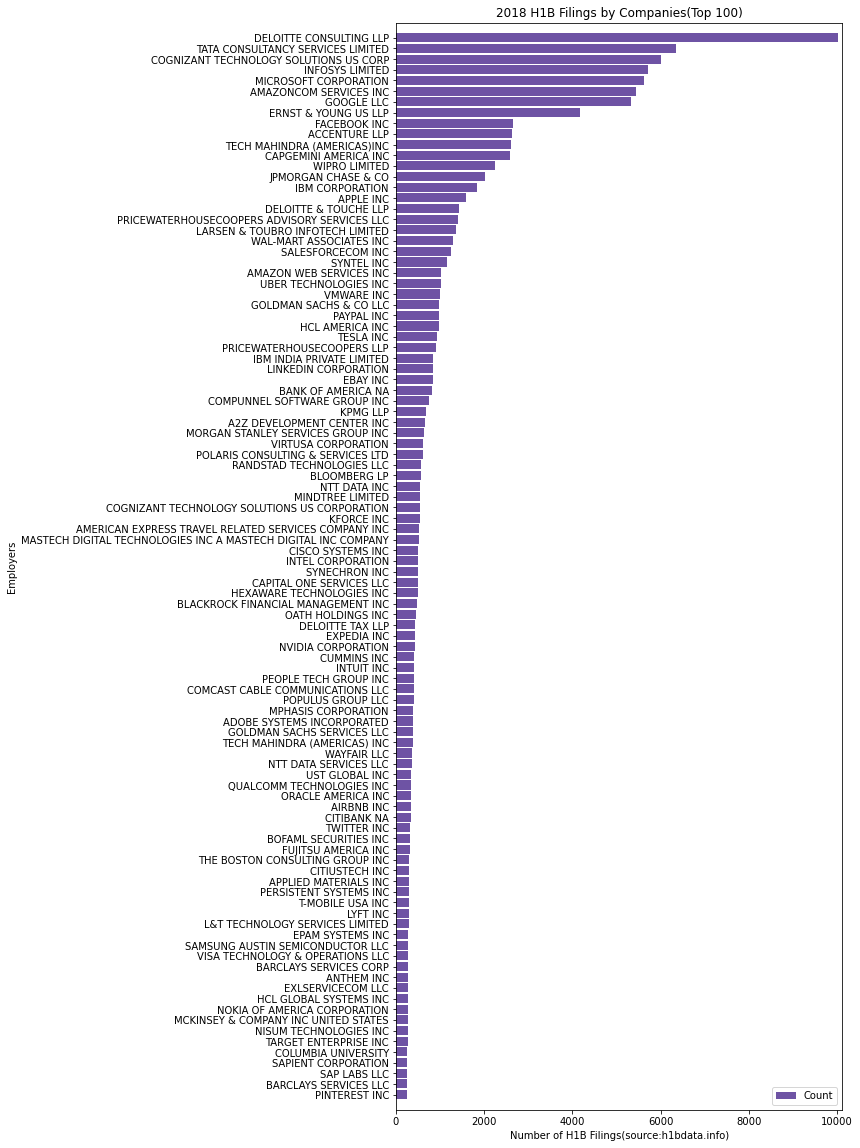

In [28]:
### Generate a bar plot, plot top 100
plt.figure(figsize = (8,20))
plt.barh(company_summary['employer'], company_summary['count'], color = '#6E53A4',height = 0.85, label ='Count')
plt.gca().invert_yaxis() # Invert axis
plt.margins(0.01) # Adjust margins
plt.xlabel('Number of H1B Filings(source:h1bdata.info)')
plt.ylabel('Employers')
plt.title('2018 H1B Filings by Companies(Top 100)')
plt.legend() # Show legend
plt.show()

In the original data set, there are Google INC and Google LLC.
After the reform, Google INC should be Google LLC.

#### Cities

In [29]:
dat_content1

,employer,base_salary,location,submit_date,start_date,case_status,city,job_title_clean
0,BARCLAYS SERVICES CORP,125000,"NEW YORK, NY",06/13/2018,07/02/2018,CERTIFIED,NEW YORK,NET QLIK DEVELOPER SYSTEMS ENGINEER
1,VLINKINC,85000,"NEW YORK, NY",12/13/2018,12/26/2018,WITHDRAWN,NEW YORK,NET ARCHITECT
2,VLINKINC,85000,"NEW YORK, NY",12/20/2018,01/03/2019,CERTIFIED,NEW YORK,NET ARCHITECT
3,DIGITAL SCRIPTS INC,92700,"NEW YORK, NY",11/12/2018,12/28/2018,CERTIFIED,NEW YORK,NET DEVELOPER
4,DIGITAL SCRIPTS INC,92800,"NEW YORK, NY",08/30/2018,12/28/2018,CERTIFIED,NEW YORK,NET DEVELOPER
...,...,...,...,...,...,...,...,...
1693,ENTREGA SYSTEMS GROUP INC,62000,"TROY, MI",03/30/2018,09/08/2018,CERTIFIED,TROY,WEB APPLICATION DEVELOPER
1694,BROADGATE INC,60000,"TROY, MI",02/20/2018,03/01/2018,CERTIFIED,TROY,WEB DEVELOPER
1695,ELIX INC,71635,"TROY, MI",03/30/2018,09/28/2018,CERTIFIED,TROY,WEB DEVELOPER
1696,PRECISION TECHNOLOGIES CORP,61420,"TROY, NY",04/17/2018,04/17/2018,CERTIFIED,TROY,WINDOWS ADMINISTRATOR


In [30]:
city_summary = (dat_content1
 .groupby('city')
 .size()
 .sort_values(ascending = False)
 .reset_index()
 .rename(columns = {0: 'count'})                  
)
city_summary

,city,count
0,NEW YORK,37323
1,SAN FRANCISCO,17194
2,CHICAGO,12076
3,HOUSTON,11525
4,SAN JOSE,11409
5,ATLANTA,10894
6,SEATTLE,10273
7,SUNNYVALE,9738
8,AUSTIN,7639
9,DALLAS,7484


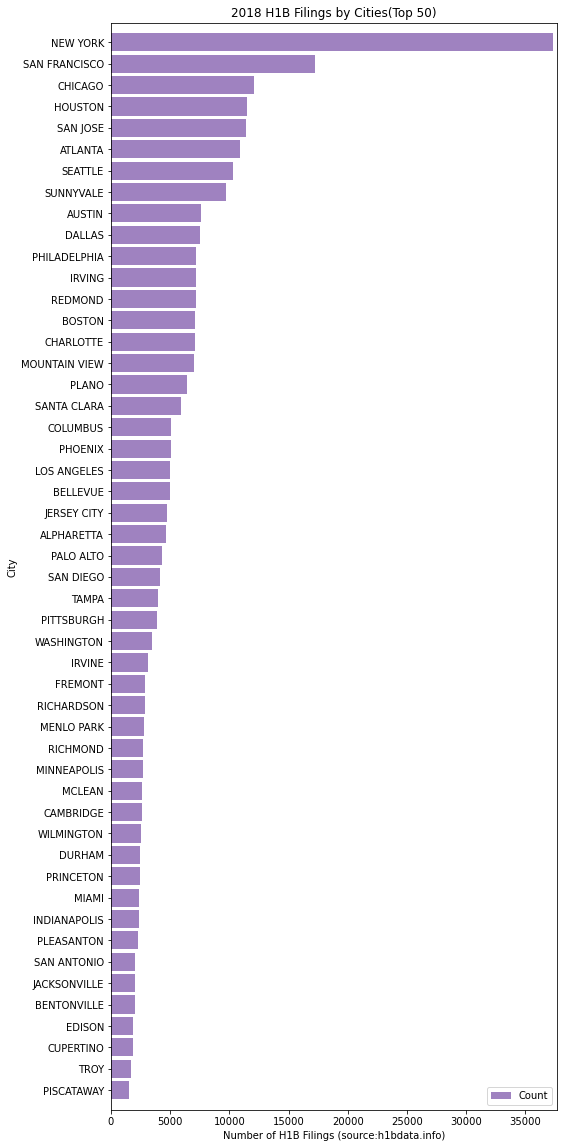

In [31]:
### Generate a bar plot, plot top 100
plt.figure(figsize = (8,20))
plt.barh(city_summary['city'], city_summary['count'], color = '#9F82C0',height = 0.85, label ='Count')
plt.gca().invert_yaxis() # Invert axis
plt.margins(0.01) # Adjust margins
plt.xlabel('Number of H1B Filings (source:h1bdata.info)')
plt.ylabel('City')
plt.title('2018 H1B Filings by Cities(Top 50)')
plt.legend() # Show legend
plt.show()

#### Job Titles

In [32]:
job_summary = (dat_content1
 .groupby('job_title_clean')
 .size()
 .sort_values(ascending = False)
 .reset_index()
 .rename(columns = {0: 'count'})
)
job_summary

,job_title_clean,count
0,SOFTWARE ENGINEER,20469
1,SOFTWARE DEVELOPER,14705
2,SENIOR SOFTWARE ENGINEER,4995
3,CONSULTANT,4090
4,PROGRAMMER ANALYST,3864
...,...,...
46742,QA ENGINEER MEMBER OF TECHNICAL STAFF,1
46743,QA ENGINEER IV,1
46744,QA ENGINEER III,1
46745,QA ENGINEER DEVELOPER,1


In [33]:
long_str = ''.join(job_summary.job_title_clean)

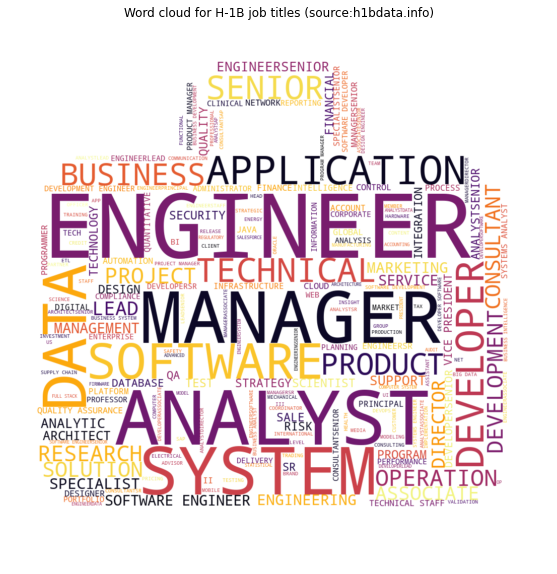

In [108]:
h1b_mask = np.array(Image.open("./images/h1b.png"))
c = wordcloud.WordCloud(background_color = "white",
              width=736,
              height=715,
              colormap=plt.cm.inferno,
              mask = h1b_mask)
wc = c.generate(long_str)
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud for H-1B job titles (source:h1bdata.info)')
plt.show()

In [35]:
job_engineer = job_summary[job_summary['job_title_clean'].str.contains("ENGINEER")] 
job_engineer

,job_title_clean,count
0,SOFTWARE ENGINEER,20469
2,SENIOR SOFTWARE ENGINEER,4995
10,SOFTWARE DEVELOPMENT ENGINEER II,1893
19,ENGINEER,1286
24,SYSTEMS ENGINEER,1092
...,...,...
46741,QA ENGINEER SOFTWARE ENGINEER IN TEST,1
46742,QA ENGINEER MEMBER OF TECHNICAL STAFF,1
46743,QA ENGINEER IV,1
46744,QA ENGINEER III,1


In [36]:
job_engineer.shape[0]/job_summary.shape[0]

0.23145870323229298

### 2. What’s the distribution of H-1B salary for those certified/ withdrawn/ denied LCAs in 2018? What’s the certified rate?

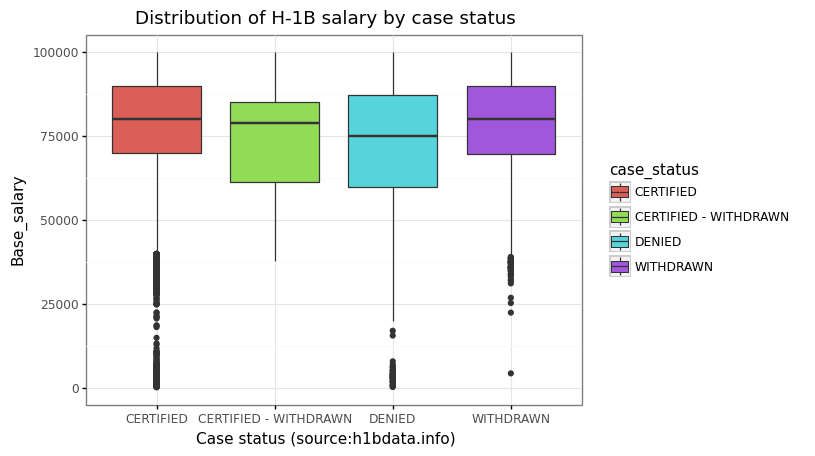

<ggplot: (8794556212474)>

In [37]:
(
    ggplot(dat_content1) +
    geom_boxplot(aes(dat_content1.case_status,dat_content1.base_salary,fill=dat_content1.case_status)) +
    ylim(0,100000)+
    theme(figure_size = (10,8))+
    theme_bw()+
    labs(title = "Distribution of H-1B salary by case status",
         x = 'Case status (source:h1bdata.info)',
         y = 'Base_salary')
)

In [38]:
p = (dat_content1
 .groupby('case_status')
 .size()
 .reset_index()
 .rename(columns = {0: 'count'})
)

In [39]:
p['percentage'] = (p['count']/dat_content1.shape[0]*100)

In [40]:
p

,case_status,count,percentage
0,CERTIFIED,277547,95.749775
1,CERTIFIED - WITHDRAWN,444,0.153174
2,DENIED,3493,1.205035
3,WITHDRAWN,8383,2.892016


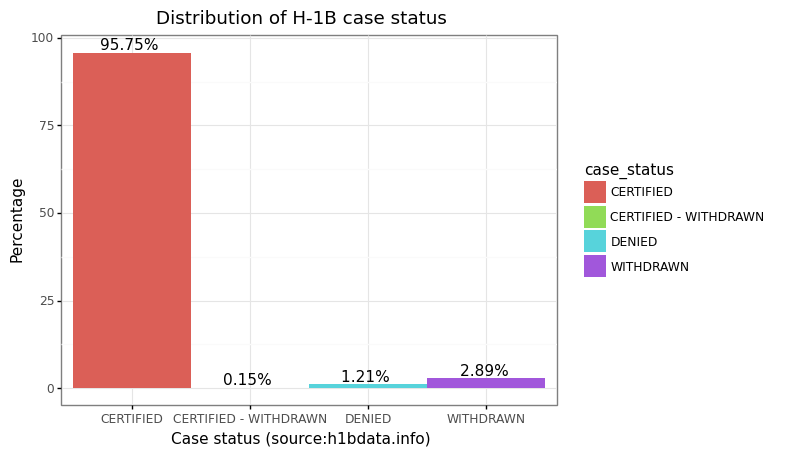

<ggplot: (8794543675781)>

In [102]:
(
    ggplot(p, aes(x='case_status', y='percentage', fill='case_status'))+
    geom_bar(width = 1, stat = "identity")+
    geom_text(aes(label = 'percentage'),
              nudge_y=0.125,
              va='bottom',
              format_string='{:.2f}% ')+
    theme_bw()+
    labs(title = "Distribution of H-1B case status",
         x = 'Case status (source:h1bdata.info)',
         y = 'Percentage')
)

### 3.Distribution of length of preparation period (submit – start)

In [42]:
###Create "n_days"
dat_content2 = dat_content1.copy()
    # split effective column
dat_content2['start_date'] = dat_content2['start_date'].astype("datetime64")
    # create start date
dat_content2['submit_date'] = dat_content2['submit_date'].astype("datetime64")
    # create end date
dat_content2['n_days'] = dat_content2['start_date'] - dat_content2['submit_date'] + timedelta(days=1)
    #Calculate preparation periods
dat_content2['n_days'] = dat_content2['n_days'].astype("string").replace('NaT','0')
    # Brush up, change data type to string and replace "NaT" with "0"
dat_content2['n_days'] = dat_content2['n_days'].str.split().str[0].astype('int')
    # Brush up, extract the number of days and change them to integer

In [43]:
n_prep = dat_content2.loc[:, ['submit_date','start_date','n_days']]

In [44]:
mean = n_prep['n_days'].mean()

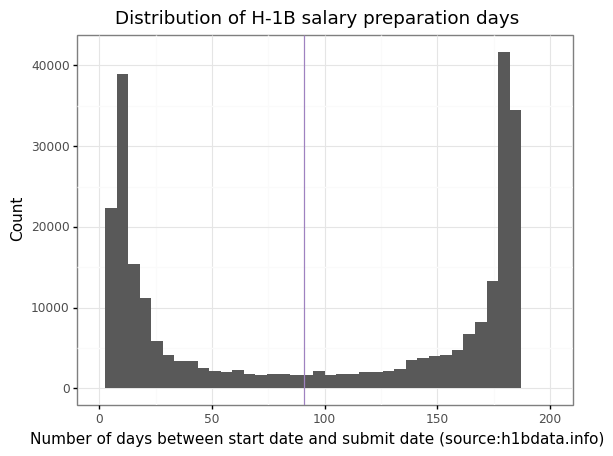

<ggplot: (8794550714757)>

In [101]:
(
    ggplot(n_prep, aes('n_days'))+
    geom_histogram()+
    xlim(0,200)+
    geom_vline(xintercept = mean, color ='#9F82C0')+
    theme_bw()+
    labs(title = "Distribution of H-1B preparation days",
     x = 'Number of days between start date and submit date (source:h1bdata.info)',
     y = 'Count')
)

### 4.What positions have the highest median salaries among certified LCAs
- Not specifying applicant number?
- applicants >10?

In [46]:
certified_LCA = dat_content2[dat_content2['case_status']=='CERTIFIED']

In [47]:
certified_LCA

,employer,base_salary,location,submit_date,start_date,case_status,city,job_title_clean,n_days
0,BARCLAYS SERVICES CORP,125000,"NEW YORK, NY",2018-06-13,2018-07-02,CERTIFIED,NEW YORK,NET QLIK DEVELOPER SYSTEMS ENGINEER,20
2,VLINKINC,85000,"NEW YORK, NY",2018-12-20,2019-01-03,CERTIFIED,NEW YORK,NET ARCHITECT,15
3,DIGITAL SCRIPTS INC,92700,"NEW YORK, NY",2018-11-12,2018-12-28,CERTIFIED,NEW YORK,NET DEVELOPER,47
4,DIGITAL SCRIPTS INC,92800,"NEW YORK, NY",2018-08-30,2018-12-28,CERTIFIED,NEW YORK,NET DEVELOPER,121
6,POPULUS GROUP LLC,144000,"NEW YORK, NY",2018-07-02,2018-07-23,CERTIFIED,NEW YORK,NET DEVELOPER,22
...,...,...,...,...,...,...,...,...,...
1693,ENTREGA SYSTEMS GROUP INC,62000,"TROY, MI",2018-03-30,2018-09-08,CERTIFIED,TROY,WEB APPLICATION DEVELOPER,163
1694,BROADGATE INC,60000,"TROY, MI",2018-02-20,2018-03-01,CERTIFIED,TROY,WEB DEVELOPER,10
1695,ELIX INC,71635,"TROY, MI",2018-03-30,2018-09-28,CERTIFIED,TROY,WEB DEVELOPER,183
1696,PRECISION TECHNOLOGIES CORP,61420,"TROY, NY",2018-04-17,2018-04-17,CERTIFIED,TROY,WINDOWS ADMINISTRATOR,1


#### Not specifying applicant numebr

In [48]:
count = (certified_LCA
 .groupby('job_title_clean')
 .size()
 .reset_index()
 .rename(columns = {0: 'count'})
 .reset_index(drop=True)
)
count.describe()

,count
count,46222.000000
mean,6.004651
std,126.645209
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,19640.000000


In [49]:
median_salary = (certified_LCA
 .groupby('job_title_clean')
 .base_salary
 .median()
 .reset_index()
 .rename(columns = {'base_salary': 'median_base_salary'})                
)
median_salary

,job_title_clean,median_base_salary
0,ASSOCIATE PRODUCT DEVELOPMENT MANAGER,63500.0
1,INFORMATION TECHNOLOGY ANALYST,93000.0
2,NET DEVELOPER,91000.0
3,09 01 2018,96500.0
4,1,85925.0
...,...,...
46217,YIELD OPTIMIZATION ASSOCIATE,63336.0
46218,YOUNG INVESTIGATOR,5962.0
46219,YOUNG PROFESSIONALS COORDINATOR,63003.0
46220,YOUTH DEVELOPMENT PROGRAM COORDINATOR,39460.0


In [50]:
certified_all = pd.merge(left = count,
         right = median_salary,
         how = "inner",      # The type of join
         on = "job_title_clean") 

In [105]:
certified_all.sort_values('median_base_salary', ascending= False).head(30).reset_index(drop = True)

,job_title_clean,count,median_base_salary
0,CHIEF INVESTMENT OFFICER SOC,1,2134381.0
1,PRESIDENT CEO,1,1900000.0
2,CHAIRMAN PRESIDENT AND CHIEF EXECUTIVE OFFICER,1,1100000.0
3,PRESIDENT REAL ESTATE CHIEF CORPORATE DEVELOP...,1,1000000.0
4,CHIEF FINANCIAL OFFICER AND PARTNER,1,992250.0
5,KFC GLOBAL CEO,1,850000.0
6,GLOBAL CHIEF MARKETING OFFICER,1,785000.0
7,EXECUTIVE VICE PRESIDENT CORPORATE MARKETING,1,700000.0
8,CHIEF SERVICES OFFICER,1,675000.0
9,SURGEON RESEARCHER,1,670000.0


#### Applicants > 10

In [52]:
count_greater_10 = (certified_LCA
 .groupby('job_title_clean')
 .size()
 .reset_index()
 .rename(columns = {0: 'count'})
 .query('count > 10')
 .reset_index(drop=True)
)
count_greater_10.describe()

,count
count,2002.000000
mean,102.438561
std,600.594033
min,11.000000
25%,15.000000
50%,24.000000
75%,54.000000
max,19640.000000


In [53]:
certified_greater10 = pd.merge(left = count_greater_10,
         right = median_salary,
         how = "inner",      # The type of join
         on = "job_title_clean") 

In [54]:
certified_greater10

,job_title_clean,count,median_base_salary
0,3D ARTIST,14,60500.0
1,AB INITIO DEVELOPER,11,84240.0
2,ABINITIO DEVELOPER,11,89000.0
3,ACCOUNT DIRECTOR,20,128981.0
4,ACCOUNT EXECUTIVE,58,63385.5
...,...,...,...
1997,WEB DEVELOPMENT ENGINEER I,14,112500.0
1998,WEB DEVELOPMENT ENGINEER II,21,117000.0
1999,WEB ENGINEER,12,103834.5
2000,WEBLOGIC ADMINISTRATOR,12,87640.0


In [55]:
certified_greater10.sort_values('median_base_salary', ascending= False).head(30).reset_index(drop=True)

,job_title_clean,count,median_base_salary
0,ADJUNCT ASSISTANT PROFESSOR,17,275000.0
1,ANESTHESIOLOGIST,11,272000.0
2,MANAGING DIRECTOR,52,240771.0
3,STAFF PHYSICIAN,18,240000.0
4,PARTNER,31,235893.0
5,ASSOCIATE PARTNER,13,229468.0
6,HOSPITALIST,79,223200.0
7,EXECUTIVE DIRECTOR,64,217500.0
8,HOSPITALIST PHYSICIAN,41,217000.0
9,ASSISTANT PROFESSOR OF CLINICAL,12,216500.0


### 5. Examine the factors that are predictive of an applicant obtaining LCA certification?
- top companies?
- base_salary?
- job_titles?
- preparation time?

#### Data Processing

#### `top100`

Top companies

In [56]:
top100_list = company_summary['employer'].to_list()

In [57]:
empin100 =[]
for e in dat_content2['employer']:
    empin100.append(1*(e in top100_list))
dat_content2['top100'] = empin100

In [58]:
dat_content2.top100.value_counts()

0    177708
1    112159
Name: top100, dtype: int64

#### `job_popular`

In [59]:
word_freq_dict = wordcloud.WordCloud().process_text(long_str)

In [60]:
word_freq = pd.DataFrame(word_freq_dict.items(), columns=['word', 'frequency'])

In [61]:
popular10_list = (word_freq
                  .sort_values('frequency', ascending = False)
                  .head(10)
                  .word
                  .to_list()
                 )

In [62]:
popular10_list

['ENGINEER',
 'ANALYST',
 'MANAGER',
 'SYSTEM',
 'DATA',
 'SOFTWARE',
 'APPLICATION',
 'DEVELOPER',
 'TECHNICAL',
 'SENIOR']

In [63]:
titlein10 =[]
for j in dat_content2['job_title_clean']: 
    temp = []
    for jsplit in j.split():
        temp.append(jsplit in popular10_list)
    titlein10.append(1*any(temp))
dat_content2['job_popular'] = titlein10

In [64]:
# l =[]
# te = dat_content2.sample(5)
# for j in te['job_title_clean']:
#     temp = []
#     for jsplit in j.split():
#         temp.append(jsplit in popular10_list)
#     l.append(1*any(temp))
# print(l)

In [65]:
# te

In [66]:
dat_content2.job_popular.value_counts()

1    212683
0     77184
Name: job_popular, dtype: int64

In [67]:
dat_content2.columns

Index(['employer', 'base_salary', 'location', 'submit_date', 'start_date',
       'case_status', 'city', 'job_title_clean', 'n_days', 'top100',
       'job_popular'],
      dtype='object')

In [68]:
dat_ml = dat_content2[['case_status','base_salary','n_days','top100','job_popular']]

In [69]:
dat_ml

,case_status,base_salary,n_days,top100,job_popular
0,CERTIFIED,125000,20,1,1
1,WITHDRAWN,85000,14,0,0
2,CERTIFIED,85000,15,0,0
3,CERTIFIED,92700,47,0,1
4,CERTIFIED,92800,121,0,1
...,...,...,...,...,...
1693,CERTIFIED,62000,163,0,1
1694,CERTIFIED,60000,10,0,1
1695,CERTIFIED,71635,183,0,1
1696,CERTIFIED,61420,1,0,0


#### `case_status`

In [70]:
dat_ml['case_status'] = 1*(dat_ml['case_status']=='CERTIFIED')

In [71]:
dat_ml

,case_status,base_salary,n_days,top100,job_popular
0,1,125000,20,1,1
1,0,85000,14,0,0
2,1,85000,15,0,0
3,1,92700,47,0,1
4,1,92800,121,0,1
...,...,...,...,...,...
1693,1,62000,163,0,1
1694,1,60000,10,0,1
1695,1,71635,183,0,1
1696,1,61420,1,0,0


#### Machine Learning(Classification Task)

In [109]:
dat = dat_ml.copy().reset_index(drop =True)

In [110]:
dat

,case_status,base_salary,n_days,top100,job_popular
0,1,125000,20,1,1
1,0,85000,14,0,0
2,1,85000,15,0,0
3,1,92700,47,0,1
4,1,92800,121,0,1
...,...,...,...,...,...
289862,1,62000,163,0,1
289863,1,60000,10,0,1
289864,1,71635,183,0,1
289865,1,61420,1,0,0


In [73]:
dat.dtypes

case_status    Int64
base_salary    int64
n_days         int64
top100         int64
job_popular    int64
dtype: object

In [74]:
for col in ['case_status', 'top100', 'job_popular']:
    dat[col] = dat[col].astype('category').astype('int')

In [75]:
y = dat[['case_status']]
X = dat.drop(columns=['case_status'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [76]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

In [77]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [78]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

In [79]:
#Put it all together in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc')

In [80]:
# Run models
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=4,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [81]:
# Best ROC AUC score
search.best_score_

0.6226489589003783

In [82]:
# Best Model
search.best_params_

{'model': RandomForestClassifier(max_depth=4, n_estimators=1500),
 'model__max_depth': 4,
 'model__n_estimators': 1500}

In [83]:
rf_mod = search.best_estimator_

#### Performance(training set)
Let's look at performance on training set.

In [84]:
train_pred_y = rf_mod.predict(train_X)
train_pred_y_proba = rf_mod.predict_proba(train_X)[:,1]

In [85]:
m.mean_squared_error(train_y,train_pred_y)

0.042088316467341305

In [86]:
m.accuracy_score(train_y,train_pred_y)

0.9579116835326587

In [87]:
m.roc_auc_score(train_y,train_pred_y_proba)

0.6246550731626518

#### Performance(test set)
Let's look at performance on test set.

In [88]:
pred_y = rf_mod.predict(test_X)
pred_y_proba = rf_mod.predict_proba(test_X)[:,1]

In [89]:
m.mean_squared_error(test_y,pred_y)

0.042005326562435316

In [90]:
m.accuracy_score(test_y,pred_y)

0.9579946734375647

In [91]:
m.roc_auc_score(test_y,pred_y_proba)

0.6231671582776218

In [92]:
print(m.classification_report(test_y,pred_y))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02      3082
           1       0.96      1.00      0.98     69385

    accuracy                           0.96     72467
   macro avg       0.98      0.51      0.50     72467
weighted avg       0.96      0.96      0.94     72467



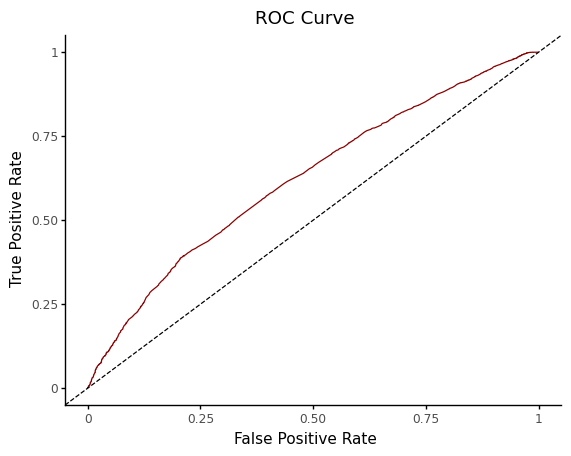

<ggplot: (8794591568827)>

In [103]:
fpr,tpr,thres = m.roc_curve(test_y,pred_y_proba)

(
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="darkred") +
    geom_abline(linetype="dashed") +
    theme_classic() +
    labs(y="True Positive Rate",x="False Positive Rate", title = 'ROC Curve')
)

#### For the most predictive model, do the following:
- (a) Examine the variable importance, which three variables does the model rely on most when making predictions? (2 Points)
- (b) Plot partial dependency plots for the top three most important variable. What does the marginal relationship tell you? (3 Points)
- (c) Plot an ICE plot for the most important variable. Is there any heterogeneity in the marginal effect across observations? If so, what might this mean? (2 Points)

In [94]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [95]:
from sklearn.inspection import permutation_importance

In [96]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)

In [97]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,n_days,7.755290e-04,0.000004,0.000768,0.000783
1,base_salary,4.599816e-06,0.000000,0.000005,0.000005
2,top100,9.199632e-07,0.000002,-0.000003,0.000005
3,job_popular,0.000000e+00,0.000000,0.000000,0.000000


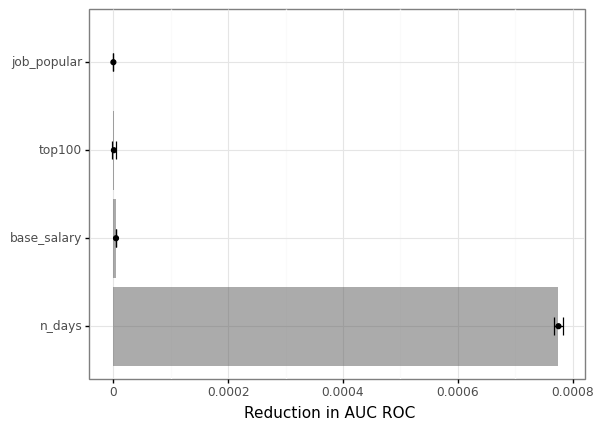

<ggplot: (8794550714763)>

In [98]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)